In [46]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# Import the Housing Data

Data comes from https://datacatalog.cookcountyil.gov/Property-Taxation/Assessor-Archived-05-11-2022-Residential-Modeling-/8f9d-wy2d

In [177]:
df_housing_csv = pd.read_csv("housing.csv", low_memory=False)


In [178]:
pd.set_option('display.max_rows', 120)
print(df_housing_csv.dtypes)

Property Index Number                         object
Assessment Triad                              object
Property Class                                 int64
Property Address                              object
Property Apartment Num.                       object
Property City                                 object
Township Name                                 object
Township Code                                  int64
Neighborhood Code                              int64
Township Neighborhood Only                     int64
Modeling Group                                object
Proportion Assessed                          float64
Key PIN                                       object
Multi Code Indicator                           int64
Multi Code                                   float64
Number of Active 288s (HIEs)                 float64
Number of Ended 288s (HIEs)                  float64
Sale Date                                     object
Sale Price                                   f

In [49]:
housing_df = df[
    [
        "Property Index Number",
        "Property Class",
        "Township Name",
        "Number of Active 288s (HIEs)",
        "Number of Ended 288s (HIEs)",
        "Sale Price",
        "Land Square Feet",
        "Large Home Indicator",
        "Age",
        "Apartments",
        "Wall Material",
        "Roof Material",
        "Rooms",
        "Bedrooms",
        "Basement",
        "Basement Finish",
        "Central Heating",
        "Central Air Conditioning",
        "Fireplaces",
        "Attic Type",
        "Full Baths",
        "Half Baths",
        "Cathedral Ceiling",
        "Garage 1 Size",
        "Garage 1 Material",
        "Garage 1 Attached",
        "Garage 1 Area",
        "Building Square Feet",
        "Repair Condition",
        "Attic Finish",
        "Renovation",
        "Porch",
        "Tract GEOID",
        "O'Hare Noise Indicator",
        "FEMA Floodplain",
        "Flood Risk Factor",
        "Flood Risk Direction",
        "Road Proximity < 100 Feet",
        "Road Proximity 101 - 300 Feet",
        "Elementary/Middle School District",
        "High School District",
        "Longitude",
        "Latitude",
        "Tax Rate",
        "Tract Median Income",
        "Modeled Sale Year",
        "Modeled Sale Month",
        "Modeled Sale Day",
        "Modeled Sale During School Year",
        "Modeled Sale During Holidays",
    ]
]

In [50]:
print(housing_df.shape)
housing_df.dropna(subset=["Sale Price"], inplace=True)
print(housing_df.shape)

(678656, 50)
(78156, 50)


/var/folders/w8/480pcx_d3bx9y45bcf4fz7800000gn/T/ipykernel_60182/85049842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df.dropna(subset=["Sale Price"], inplace=True)


In [51]:
if 'Property Index Number' in housing_df.columns:
	housing_df.set_index('Property Index Number', inplace=True)
	
for x in housing_df.columns:
	if housing_df[x].dtype == 'object':
		housing_df[x].replace(housing_df[x].unique(), range(len(housing_df[x].unique())), inplace=True)
		housing_df[x] = housing_df[x].astype('category')
		
housing_df = housing_df.dropna()

/var/folders/w8/480pcx_d3bx9y45bcf4fz7800000gn/T/ipykernel_60182/3840300183.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df[x].replace(housing_df[x].unique(), range(len(housing_df[x].unique())), inplace=True)
/var/folders/w8/480pcx_d3bx9y45bcf4fz7800000gn/T/ipykernel_60182/3840300183.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df[x] = housing_df[x].astype('category')


# Summary Statistics

In [179]:
print("There are", housing_df['Sale Price'].count(), "rows of data!")
    
max_val = df_housing_csv['Sale Price'].max()
min_val = df_housing_csv['Sale Price'].min()
mean_val = df_housing_csv['Sale Price'].mean()
q3 = np.nanquantile(df_housing_csv['Sale Price'], 0.75)
median = np.nanquantile(df_housing_csv['Sale Price'], 0.5)
q1 = np.nanquantile(df_housing_csv['Sale Price'], 0.25)
print('The average Sale Price is', mean_val)
print('The minimum Sale Price is', min_val)
print('The 25th percentile value is', q1)
print('The median percentile value is', median)
print('The 75th percentile value is', q3)
print('The maximum Sale Price is', max_val)

There are 45572 rows of data!
The average Sale Price is 347982.84404268384
The minimum Sale Price is 10000.0
The 25th percentile value is 170000.0
The median percentile value is 270000.0
The 75th percentile value is 425000.0
The maximum Sale Price is 9400000.0


In [153]:
import sklearn.linear_model as lm
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Training and Testing Data

In [189]:
X = df.drop('Sale Price', axis = 1)
y = df['Sale Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=491)

# Ridge Regression

In [184]:
ridge = lm.Ridge(fit_intercept=True)
sfs = SequentialFeatureSelector(ridge, n_features_to_select='auto', direction='forward', tol=0.001)
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=Ridge(), n_features_to_select='auto',
                          tol=0.001)

In [185]:
sfs.get_support()
ridge_important = sfs.get_feature_names_out()
ridge_important

array(['Large Home Indicator', 'Apartments', 'Roof Material', 'Rooms',
       'Basement Finish', 'Central Air Conditioning', 'Fireplaces',
       'Full Baths', 'Building Square Feet', 'Renovation',
       'Elementary/Middle School District', 'Longitude', 'Latitude',
       'Tract Median Income'], dtype=object)

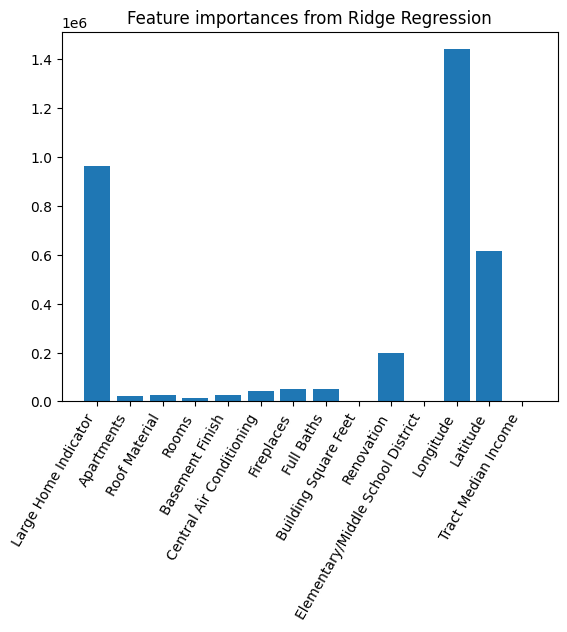

In [186]:
# train_x = housing_df[important].sample(frac=0.8)
# train_y = housing_df['Sale Price'].sample(frac=0.8)

# test_y = housing_df[~housing_df['Sale Price'].isin(train_y)]

ridge_model = lm.RidgeCV(fit_intercept= True).fit(X=X_train[ridge_important] , y=y_train)
importance = np.abs(ridge_model.coef_)
plt.bar(height=importance, x=ridge_important)
plt.title("Feature importances from Ridge Regression")
plt.xticks(rotation=60, ha = 'right')
plt.show()

In [88]:
# train_x = sfs.transform(housing_df.drop('Sale Price', axis=1).sample(frac=0.8))
# train_y = housing_df['Sale Price'].sample(frac=0.8)
# test_y = housing_df[~housing_df['Sale Price'].isin(train_y)]


# LASSO

In [190]:
lm2 = lm.Lasso(fit_intercept=True)
sfs2 = SequentialFeatureSelector(lm2, n_features_to_select='auto', direction='forward', tol=0.001)
sfs2.fit(X_train, y_train)
sfs2.get_support()
lasso_important = sfs2.get_feature_names_out()
lasso_important


array(['Large Home Indicator', 'Apartments', 'Roof Material', 'Rooms',
       'Basement Finish', 'Central Air Conditioning', 'Fireplaces',
       'Full Baths', 'Building Square Feet', 'Renovation',
       'Elementary/Middle School District', 'Longitude', 'Latitude',
       'Tract Median Income'], dtype=object)

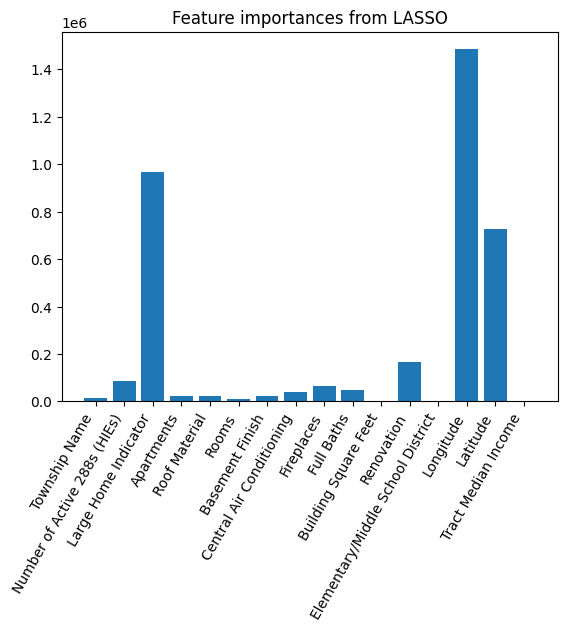

In [155]:
# lasso_train_x = housing_df[important2].sample(frac=0.8)
# lasso_train_y = housing_df['Sale Price'].sample(frac=0.8)

# lasso_test_x = housing_df[~housing_df[important2].isin(lasso_train_x)]
# lasso_test_x = housing_df.loc[~lasso_train_x, important2]
# lasso_test_y = housing_df[~housing_df['Sale Price'].isin(lasso_train_y)]

lasso_model = lm.Lasso(fit_intercept= True).fit(X=X_train[lasso_important], y=y_train)
importance2 = np.abs(lasso_model.coef_)
plt.bar(height=importance2, x=lasso_important)
plt.title("Feature importances from LASSO")
plt.xticks(rotation=60, ha= 'right')
plt.show()

In [157]:
lasso_pred = lasso_model.predict(X_test[lasso_important])

mse = mean_squared_error(y_test, lasso_pred)
print(mse)

50414831092.59797


In [91]:
crime_df = pd.read_csv("crimes.csv", low_memory=False)
tract_boundaries = gpd.read_file('b.geojson')
parks = gpd.read_file("park.geojson")

In [92]:
crime_df = crime_df[crime_df['Latitude'] > 41 ]
crime_df = crime_df[crime_df['Latitude'] < 43]
crime_df = crime_df[crime_df['Longitude'] > -88]
crime_df = crime_df[crime_df['Longitude'] < -87.5]

## Add Census Tract to the Crimes Dataset

crs is the coordinate system and EPSG:4326 is just Earth's longitude and latitude

gpd.sjoin() joins the data sets where each row in the first df is within the 'shape' of the second df

In [93]:
crime_gdf = gpd.GeoDataFrame(
    crime_df,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(crime_df. Longitude, crime_df.Latitude),
)
crime_gdf = gpd.sjoin(crime_gdf, tract_boundaries, how="left", predicate="within")

parks_gdf = gpd.GeoDataFrame(
    parks,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(parks.x_coord, parks.y_coord),
)
parks_gdf = gpd.sjoin(parks_gdf, tract_boundaries, how="left", predicate="within")

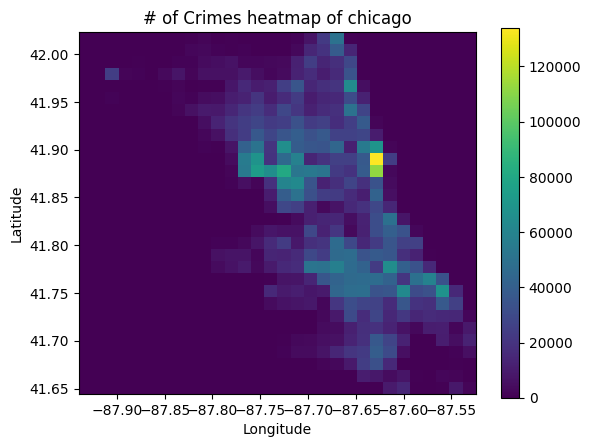

In [ ]:
df = crime_gdf.dropna(subset=['Longitude', 'Latitude'])

heatmap, xedges, yedges = np.histogram2d(df.Longitude, df.Latitude, bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.title("# of Crimes heatmap of chicago")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

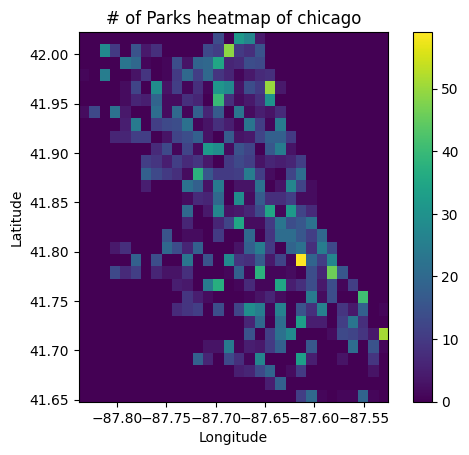

In [ ]:
df = parks_gdf.dropna(subset=['x_coord', 'y_coord'])
df.x_coord = df.x_coord.astype(float)
df.y_coord = df.y_coord.astype(float)
heatmap, xedges, yedges = np.histogram2d(df.x_coord, df.y_coord, bins=30)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.title("# of Parks heatmap of chicago")
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar()
plt.show()

# Data Cleaning

In [180]:
housing_df["geoid"] = housing_df["Tract GEOID"]
crime_gdf["geoid"] = crime_gdf["geoid10"]
parks_gdf["geoid"] = parks_gdf["geoid10"]

crime_counts = crime_gdf["geoid"].value_counts().rename_axis("geoid").reset_index(name="crime_counts").astype('int64')
park_counts = parks_gdf["geoid"].value_counts().rename_axis("geoid").reset_index(name="park_counts").astype('int64')
avg_house_sale = housing_df.groupby("geoid", as_index=False)["Sale Price"].mean()

df = pd.merge(housing_df, crime_counts, on = "geoid", how="left")
df = pd.merge(df, park_counts, on="geoid", how="left")

df = df.dropna()
df.head()

,Property Class,Township Name,Number of Active 288s (HIEs),Number of Ended 288s (HIEs),Sale Price,Land Square Feet,Large Home Indicator,Age,Apartments,Wall Material,...,Tax Rate,Tract Median Income,Modeled Sale Year,Modeled Sale Month,Modeled Sale Day,Modeled Sale During School Year,Modeled Sale During Holidays,geoid,crime_counts,park_counts
0,205,1,0.0,0.0,367500.0,4375.0,1,72,0,1,...,6.889412,133622,2021,288,8766,True,True,17031120100,2074.0,16.0
3,203,1,0.0,0.0,288000.0,4062.0,1,94,0,2,...,6.889412,103733,2021,288,8766,True,True,17031090200,4582.0,15.0
5,203,1,0.0,0.0,575000.0,6200.0,1,105,0,3,...,6.889412,103733,2021,288,8766,True,True,17031090200,4582.0,15.0
6,203,1,0.0,0.0,545000.0,6250.0,1,68,0,2,...,6.889412,133622,2021,288,8766,True,True,17031120100,2074.0,16.0
7,278,1,0.0,0.0,950000.0,7350.0,1,3,0,2,...,6.889412,103733,2021,288,8766,True,True,17031090200,4582.0,15.0


# Visualizations of Data

Text(0, 0.5, 'Frequency')

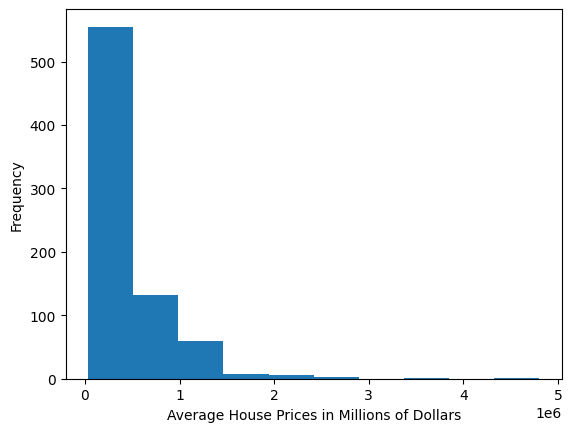

In [167]:
plt.hist(df['Sale Price'])
plt.xlabel("Average House Prices in Millions of Dollars")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

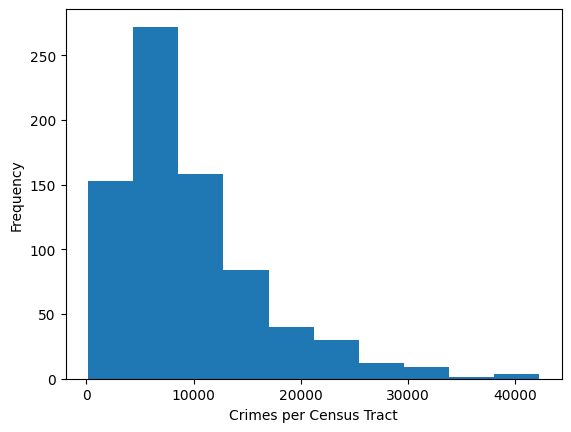

In [168]:
plt.hist(df['crime_counts'])
plt.xlabel("Crimes per Census Tract")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

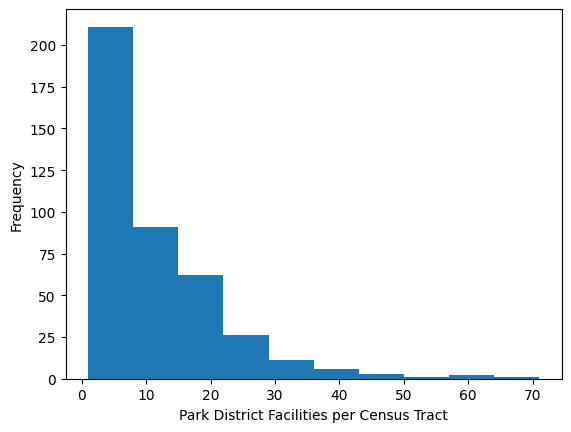

In [169]:
plt.hist(df['park_counts'])
plt.xlabel("Park District Facilities per Census Tract")
plt.ylabel("Frequency")

Plots showing the correlation between average sale price and crime then number of parks, respectively.

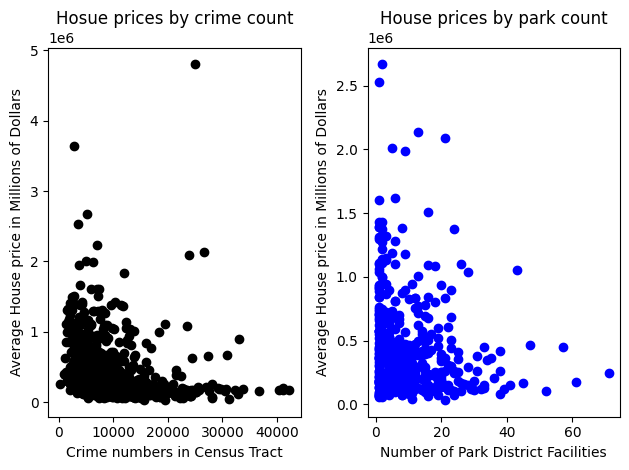

In [170]:

plt.subplot(1, 2, 1)
plt.plot(df['crime_counts'], df['Sale Price'], 'o', color='black')
plt.title('Hosue prices by crime count')
plt.xlabel('Crime numbers in Census Tract')
plt.ylabel('Average House price in Millions of Dollars')
plt.subplot(1, 2, 2)
plt.plot(df['park_counts'], df['Sale Price'], 'o', color='blue')
plt.title('House prices by park count')
plt.xlabel('Number of Park District Facilities')
plt.ylabel('Average House price in Millions of Dollars')
plt.tight_layout()
plt.show()

# Implementing Methods of Prediction

## Cross Validation with Linear Regression

In [171]:
train = df.sample(frac= 0.8, random_state= 491)
train = train.dropna()

test = pd.merge(df, train, on= ['geoid', 'Sale Price', 'crime_counts', 'park_counts'], how= 'left', indicator= True)
test = df[test['_merge'] == 'left_only']
test = test.dropna()
test.head()

,geoid,Sale Price,crime_counts,park_counts
1,17031010201,423062.266667,12629.0,17.0
2,17031010202,473000.000000,14955.0,9.0
5,17031010501,631812.500000,7254.0,2.0
14,17031020302,393222.403509,5804.0,12.0
16,17031020500,463549.125000,10210.0,47.0


In [172]:
linmodel = lm.LinearRegression(fit_intercept= True).fit(X=train[['crime_counts', 'park_counts']] , y=train['Sale Price'])

In [173]:
predictions = linmodel.predict(test[['crime_counts', 'park_counts']])

total = 0
for i in range(len(predictions)):
    error = test['Sale Price'].iloc[i] - predictions[i]
    total += error**2
MSE = total/len(predictions)
MSE

77494204932.0792

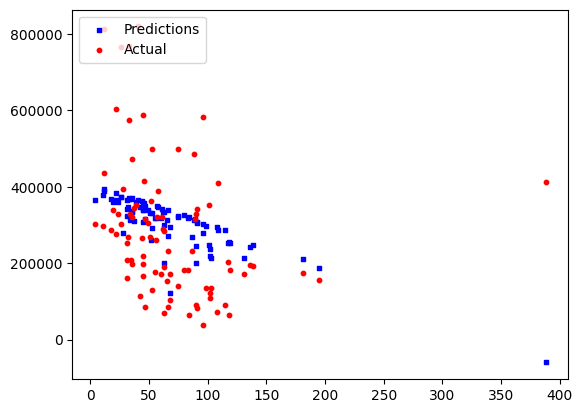

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(test[['crime_counts']], predictions, s=10, c='b', marker="s", label='Predictions')
ax1.scatter(test[['crime_counts']], test['meta_sale_price'], s=10, c='r', marker="o", label='Actual')
plt.legend(loc='upper left')
plt.show()

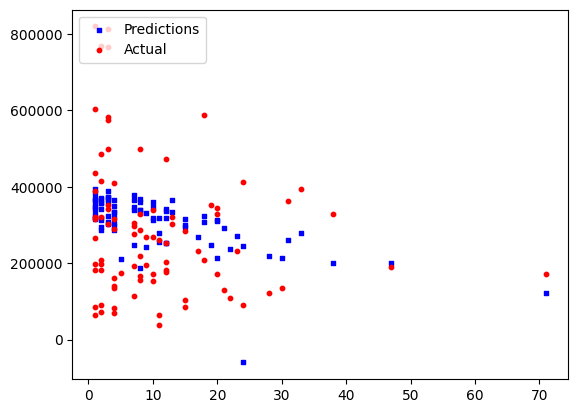

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(test[['park_counts']], predictions, s=10, c='b', marker="s", label='Predictions')
ax1.scatter(test[['park_counts']], test['meta_sale_price'], s=10, c='r', marker="o", label='Actual')
plt.legend(loc='upper left')
plt.show()

## Lasso Method

In [ ]:
lasso_model = lm.LassoCV(fit_intercept= True).fit(X=train[['crime_counts', 'park_counts']] , y=train['meta_sale_price'])

In [ ]:
lasso_pred = lasso_model.predict(test[['crime_counts', 'park_counts']])

total = 0
for i in range(len(lasso_pred)):
    error = test['meta_sale_price'].iloc[i] - lasso_pred[i]
    total += error**2
lasso_MSE = total/len(lasso_pred)
lasso_MSE

28387066222.679073

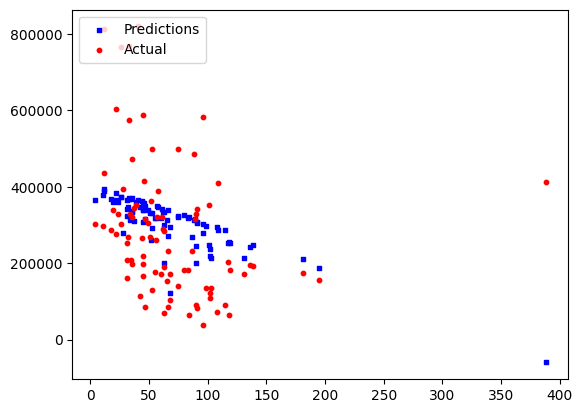

In [ ]:
fig = plt.figure()
ax2 = fig.add_subplot(1, 1, 1)
ax2.scatter(test[['crime_counts']], lasso_pred, s=10, c='b', marker="s", label='Predictions')
ax2.scatter(test[['crime_counts']], test['meta_sale_price'], s=10, c='r', marker="o", label='Actual')
plt.legend(loc='upper left')
plt.show()

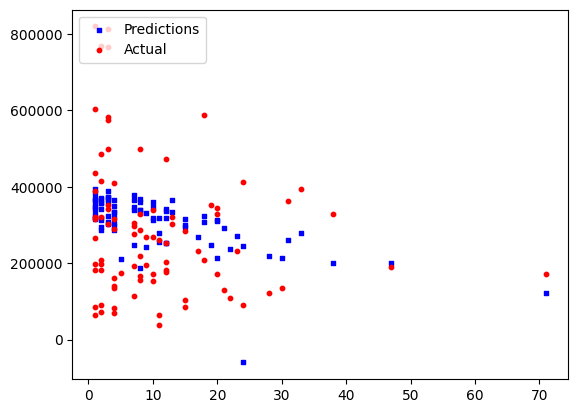

In [ ]:
fig = plt.figure()
ax2 = fig.add_subplot(1, 1, 1)
ax2.scatter(test[['park_counts']], lasso_pred, s=10, c='b', marker="s", label='Predictions')
ax2.scatter(test[['park_counts']], test['meta_sale_price'], s=10, c='r', marker="o", label='Actual')
plt.legend(loc='upper left')
plt.show()

In [ ]:
ridge_model = lm.RidgeCV(fit_intercept= True).fit(X=train[['crime_counts', 'park_counts']] , y=train['meta_sale_price'])

In [ ]:
ridge_pred = ridge_model.predict(test[['crime_counts', 'park_counts']])

total = 0
for i in range(len(ridge_pred)):
    error = test['meta_sale_price'].iloc[i] - ridge_pred[i]
    total += error**2
ridge_MSE = total/len(ridge_pred)
ridge_MSE

28386890543.700768

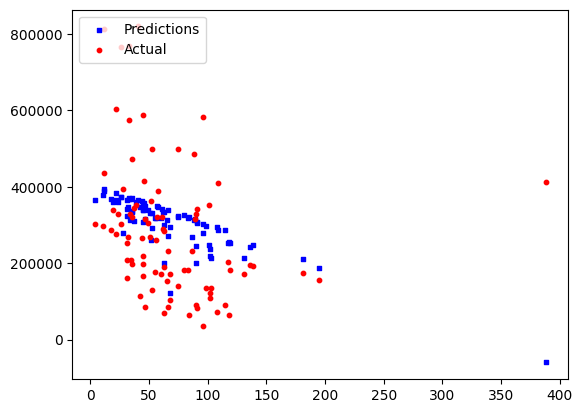

In [ ]:
fig = plt.figure()
ax3 = fig.add_subplot(1, 1, 1)
ax3.scatter(test[['crime_counts']], ridge_pred, s=10, c='b', marker="s", label='Predictions')
ax3.scatter(test[['crime_counts']], test['meta_sale_price'], s=10, c='r', marker="o", label='Actual')
plt.legend(loc='upper left')
plt.show()

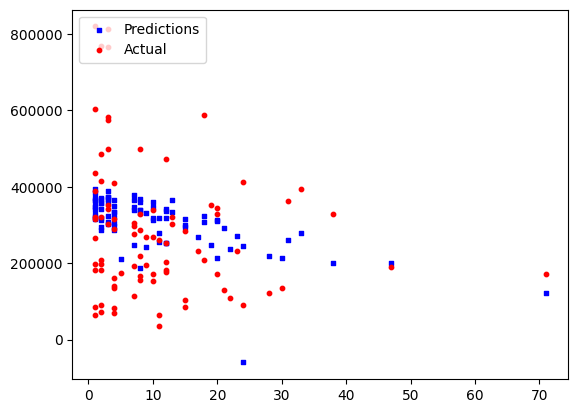

In [ ]:
fig = plt.figure()
ax3 = fig.add_subplot(1, 1, 1)
ax3.scatter(test[['park_counts']], ridge_pred, s=10, c='b', marker="s", label='Predictions')
ax3.scatter(test[['park_counts']], test['meta_sale_price'], s=10, c='r', marker="o", label='Actual')
plt.legend(loc='upper left')
plt.show()

In [ ]:
## CONSIDER CHECKING TRAINING MSE

# lin_train = linmodel.predict(train[['crime_counts', 'park_counts']])
# lasso_train = lasso_model.predict(train[['crime_counts', 'park_counts']])
# ridge_train = ridge_model.predict(train[['crime_counts', 'park_counts']])

# total = 0
# for i in range(len(ridge_pred)):
#     error = test['meta_sale_price'].iloc[i] - ridge_pred[i]
#     total += error**2
# ridge_MSE = total/len(ridge_pred)

np.argmin([MSE, lasso_MSE, ridge_MSE])

2

While the difference between the prediction models appear negligible, it is important to not that the y-values have a large spread. Small reductions in test MSE will not be apparent on the sctatterplots.